In [21]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 14

HL_THRESH = 20

lcrc, bbdc = pd.read_excel(
  'data/patients.xlsx',
  sheet_name=['Aud_LCRC','Aud_BBDC'],
  na_values=['','.','<No Form>','Unknown','Unknown or Not Reported']
).values()

bbdc = bbdc.rename(columns={'DateOfVisit':'VisitDate'})

# combine data sets
patients = lcrc.append(bbdc, sort=True).sort_values('VisitDate')
patients['Age'] = (patients.VisitDate - patients.DOB).dt.days/365

# necessary for grouping by ID
patients['LCRC ID'] = patients['LCRC ID'].fillna(-1).astype(int)
patients['BBDC ID'] = patients['BBDC ID'].fillna(-1).astype(int)
# patients = patients.groupby(['LCRC ID','BBDC ID']).ffill().drop_duplicates(['LCRC ID','BBDC ID'], keep='last')

dobs = pd.read_excel('data/bbdc_no_dob.xlsx').rename(columns={'LCRC_ID':'LCRC ID'})
dobs['LCRC ID'] = dobs['LCRC ID'].fillna(-1).astype(int)
dobs['BBDC ID'] = dobs['BBDC ID'].fillna(-1).astype(int)

patients = patients.merge(dobs[['LCRC ID','BBDC ID','Age At Visit']], how='left', on=['LCRC ID','BBDC ID'])
patients['Age'] = patients['Age'].where(patients['Age'].notnull(), patients['Age At Visit'])

# drop OI subtypes II and II/III and null subtype
patients = patients[~patients['Subtype of OI'].isin([np.nan,'II','II/III'])]

# patients = patients.dropna(subset=['L Air PTA','L Bone PTA','R Air PTA','R Bone PTA'],how='all')

def filter_records(patient):
  completest_records = patient.loc[patient.notnull().sum(1) == patient.notnull().sum(1).max()]
  return completest_records.loc[[completest_records['VisitDate'].idxmax()]]
    
patients = patients.groupby(['LCRC ID','BBDC ID']).apply(filter_records).reset_index(drop=True)

# add features
patients['consortium'] = np.where(patients['BBDC ID'] != -1,'BBDC','LCRC') # use BBDC over LCRC if patient was in both
patients['consortium_ID'] = np.where(patients['BBDC ID'] != -1,patients['BBDC ID'],patients['LCRC ID'])
# patients['age_bin'] = patients['Age'].floordiv(10).mul(10).clip_upper(60).fillna(-1).astype(int) # we chose ">60" as highest bucket

# assign UIDs
patients = patients.reset_index(drop=True)
patients['UID'] = patients.index

# NOTE: Negative PTA == healthy

In [461]:
# split into ear-level data
ears = patients.drop(['Age At Visit'],1).melt(
  id_vars=['UID','Gender','VisitDate','Subtype of OI','Age','consortium','consortium_ID'],
  value_name='dB_loss'
).rename(columns={'Subtype of OI': 'subtype_of_OI'})
ears['variable'] = ears['variable'].str.replace('(?<=\d)K','000').str.replace('\s*','').str.lower()
ears = ears[ears['variable'].str.contains('air|bone')]
ears = ears[~ears['variable'].str.contains('nr$|nt$')]
ears['side'] = np.where(ears['variable'].str.contains('left'),'left','right')
ears['type'] = np.where(ears['variable'].str.contains('air'),'air','bone')
ears['freq'] = ears['variable'].str.extract('(\d+)')[0].astype(int)
ears['dB_loss'] = ears['dB_loss'].astype(float)
# ears = ears.dropna()
# ears = ears.drop(['variable','VisitDate'],1)
# ears = ears.set_index(['UID','side','type','freq']).to_xarray()
# ears.variable = ears['variable'].str.lower().str.replace('^l\s|^r\s|\s','')
# ears.set_index([c for c in ears.columns if c != 'value'], inplace=True)
# ears = ears['value'].unstack('variable').reset_index()

# # ensure airbonegap is calculated correctly
# ears.eval('airbonegap = airpta - bonepta', inplace=True)

# # ensure there aren't instances where we could impute one value from the other two
# assert ears[['airpta','bonepta','airbonegap']].count(1).ne(2).all()

# # drop ears with any missing data
# # IMPORTANT: only 195 ears have nonnull airbonegap, and only 383 have nonnull bonepta (all 628 have nonnull airpta)

# ears.loc[ears.eval('airpta > @HL_THRESH and bonepta <= @HL_THRESH'),'HL_type'] = 'CHL'
# ears.loc[ears.eval('airpta > @HL_THRESH and bonepta > @HL_THRESH and airbonegap < 15'),'HL_type'] = 'SNHL'
# ears.loc[ears.eval('airpta > @HL_THRESH and bonepta > @HL_THRESH and airbonegap >= 15'),'HL_type'] = 'MHL'

# # add ear-level features
# ears.eval('''
#   CHL = HL_type == "CHL"
#   SNHL = HL_type == "SNHL"
#   MHL = HL_type == "MHL"
# ''',inplace=True)

# # ensure the HL types are mutually exclusive:
# assert ears[['CHL','SNHL','MHL']].sum(1).max() == 1

# # make copy of unfiltered ears
# ears_unf = ears.copy()

# # drop ears with any missing data
# # IMPORTANT: only 195 ears have nonnull airbonegap, and only 383 have nonnull bonepta (all 628 have nonnull airpta)
# print(len(ears))
# ears.query('airpta.notnull() and bonepta.notnull() and airbonegap.notnull()', inplace=True)
# print(len(ears))

# # drop patients without both air PTA and bone PTA
# # NOTE: Must do this after the ears data set is generated
# patients = patients.dropna(subset=['R Air PTA','L Air PTA'], how='any')

In [462]:
import holoviews as hv
hv.extension('bokeh', logo=False)

ears = hv.Dataset(ears, kdims=['UID','side','type','freq','Gender','subtype_of_OI'], vdims=['dB_loss','Age'])

In [464]:
tmp = ears.reduce(['UID','side'],np.mean,np.std).sort('freq')
tmp = tmp.to(hv.Curve, kdims='freq') * tmp.to(hv.Spread, kdims='freq')
tmp.overlay('Gender').opts(logx=True).layout('subtype_of_OI').cols(3)

/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/holoviews/element/chart.py:129: RuntimeWarning: All-NaN slice encountered
  lower = np.nanmin(mean-neg_error)
/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/holoviews/element/chart.py:130: RuntimeWarning: All-NaN slice encountered
  upper = np.nanmax(mean+pos_error)
/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/holoviews/element/chart.py:129: RuntimeWarning: All-NaN slice encountered
  lower = np.nanmin(mean-neg_error)
/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/holoviews/element/chart.py:130: RuntimeWarning: All-NaN slice encountered
  upper = np.nanmax(mean+pos_error)
/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/holoviews/element/chart.py:129: RuntimeWarning: All-NaN slice encountered
  lower = np.nanmin(mean-neg_error)
/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/holoviews/element/chart.py:130: RuntimeWarning: All-NaN slice encountered
  upper = np.nanmax(me

:NdLayout   [subtype_of_OI]
   :HoloMap   [type]
      :NdOverlay   [Gender]
         :Overlay
            .Curve.I  :Curve   [freq]   (dB_loss,Age,dB_loss_std,Age_std)
            .Spread.I :Spread   [freq]   (dB_loss,Age,dB_loss_std,Age_std)

In [444]:
tmp = hv.Dataset(ears, kdims=['UID','side','type','freq'], vdims=['dB_loss','Age','Gender','subtype_of_OI'])
tmp.data['Age'] = np.round(tmp.data['Age'])
tmp.data = tmp.data.dropna()

In [447]:
tmp.data#.to(hv.HeatMap, ['Age','freq'], 'dB_loss')

,UID,Gender,VisitDate,subtype_of_OI,Age,consortium,consortium_ID,variable,dB_loss,side,type,freq
217,217,Male,2009-09-28,IV,30.0,LCRC,100228,airconductionrightear1000,10.0,right,air,1000
218,218,Female,2009-09-17,IV,40.0,BBDC,142073,airconductionrightear1000,10.0,right,air,1000
219,219,Male,2010-01-22,I,20.0,LCRC,100231,airconductionrightear1000,5.0,right,air,1000
221,221,Female,2011-10-11,I,9.0,LCRC,100234,airconductionrightear1000,5.0,right,air,1000
222,222,Male,2009-10-13,IV,8.0,LCRC,100254,airconductionrightear1000,10.0,right,air,1000
223,223,Male,2010-02-26,I,45.0,LCRC,100255,airconductionrightear1000,30.0,right,air,1000
224,224,Male,2010-03-17,I,11.0,LCRC,100259,airconductionrightear1000,15.0,right,air,1000
225,225,Male,2011-06-14,I,12.0,LCRC,100265,airconductionrightear1000,10.0,right,air,1000
226,226,Male,2009-12-08,III,10.0,LCRC,100266,airconductionrightear1000,5.0,right,air,1000
228,228,Female,2011-03-23,V,4.0,LCRC,100275,airconductionrightear1000,20.0,right,air,1000


In [355]:
ears.data

,UID,Gender,VisitDate,subtype_of_OI,Age,consortium,consortium_ID,variable,dB_loss,side,type,freq
0,0,Male,2016-11-30,IV,15.901370,BBDC,137481,airconductionrightear1000,NaN,right,air,1000
1,1,Male,2015-09-10,III,1.197260,BBDC,137706,airconductionrightear1000,NaN,right,air,1000
2,2,Male,2016-11-30,III,14.575342,BBDC,137930,airconductionrightear1000,NaN,right,air,1000
3,3,Male,2016-10-21,I,8.619178,BBDC,137946,airconductionrightear1000,NaN,right,air,1000
4,4,Female,2015-09-18,I,6.419178,BBDC,137947,airconductionrightear1000,NaN,right,air,1000
5,5,Female,2016-10-31,I,42.652055,BBDC,137987,airconductionrightear1000,NaN,right,air,1000
6,6,Female,2016-11-30,IV,7.600000,BBDC,138219,airconductionrightear1000,NaN,right,air,1000
7,7,Female,2015-04-03,I,10.345205,BBDC,138563,airconductionrightear1000,NaN,right,air,1000
8,8,Male,2015-04-03,I,7.608219,BBDC,138564,airconductionrightear1000,NaN,right,air,1000
9,9,Female,2015-10-20,III,29.205479,BBDC,138565,airconductionrightear1000,NaN,right,air,1000


/Users/Jake/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


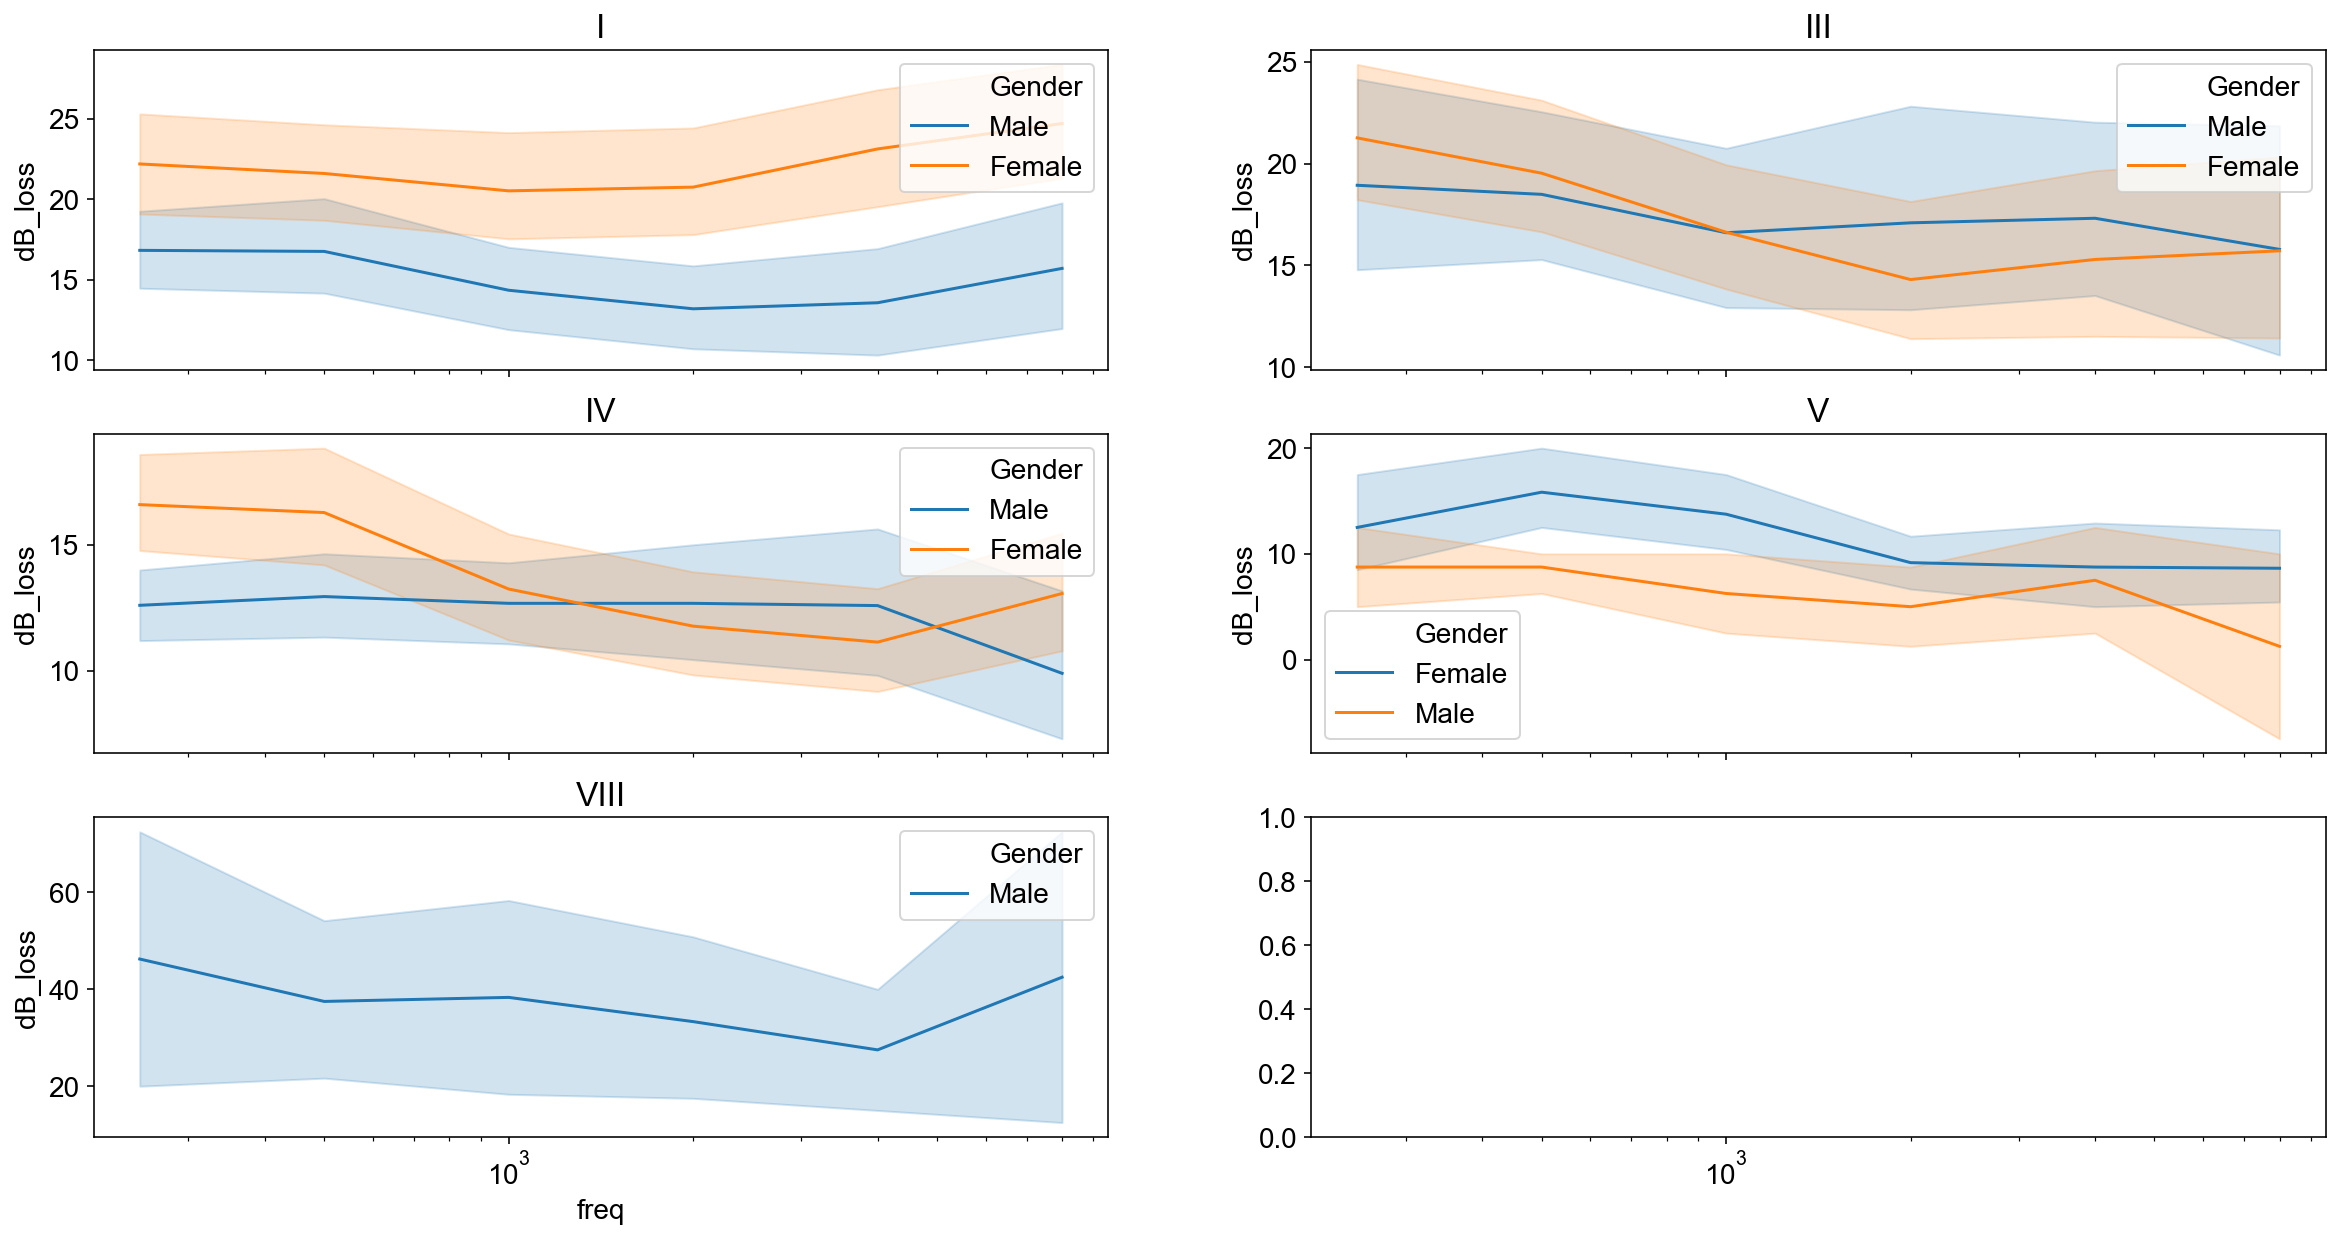

In [9]:
import seaborn as sns
for (oi, x), ax in zip(ears[ears['type']=='air'].groupby('Subtype of OI'), [i for j in plt.subplots(3,2,figsize=(20,10),sharex=True,sharey=False)[1] for i in j]):
  sns.lineplot(data=x, x='freq', y='dB_loss', hue='Gender', ax=ax)
  ax.set_title(oi)
  ax.set_xscale('log')

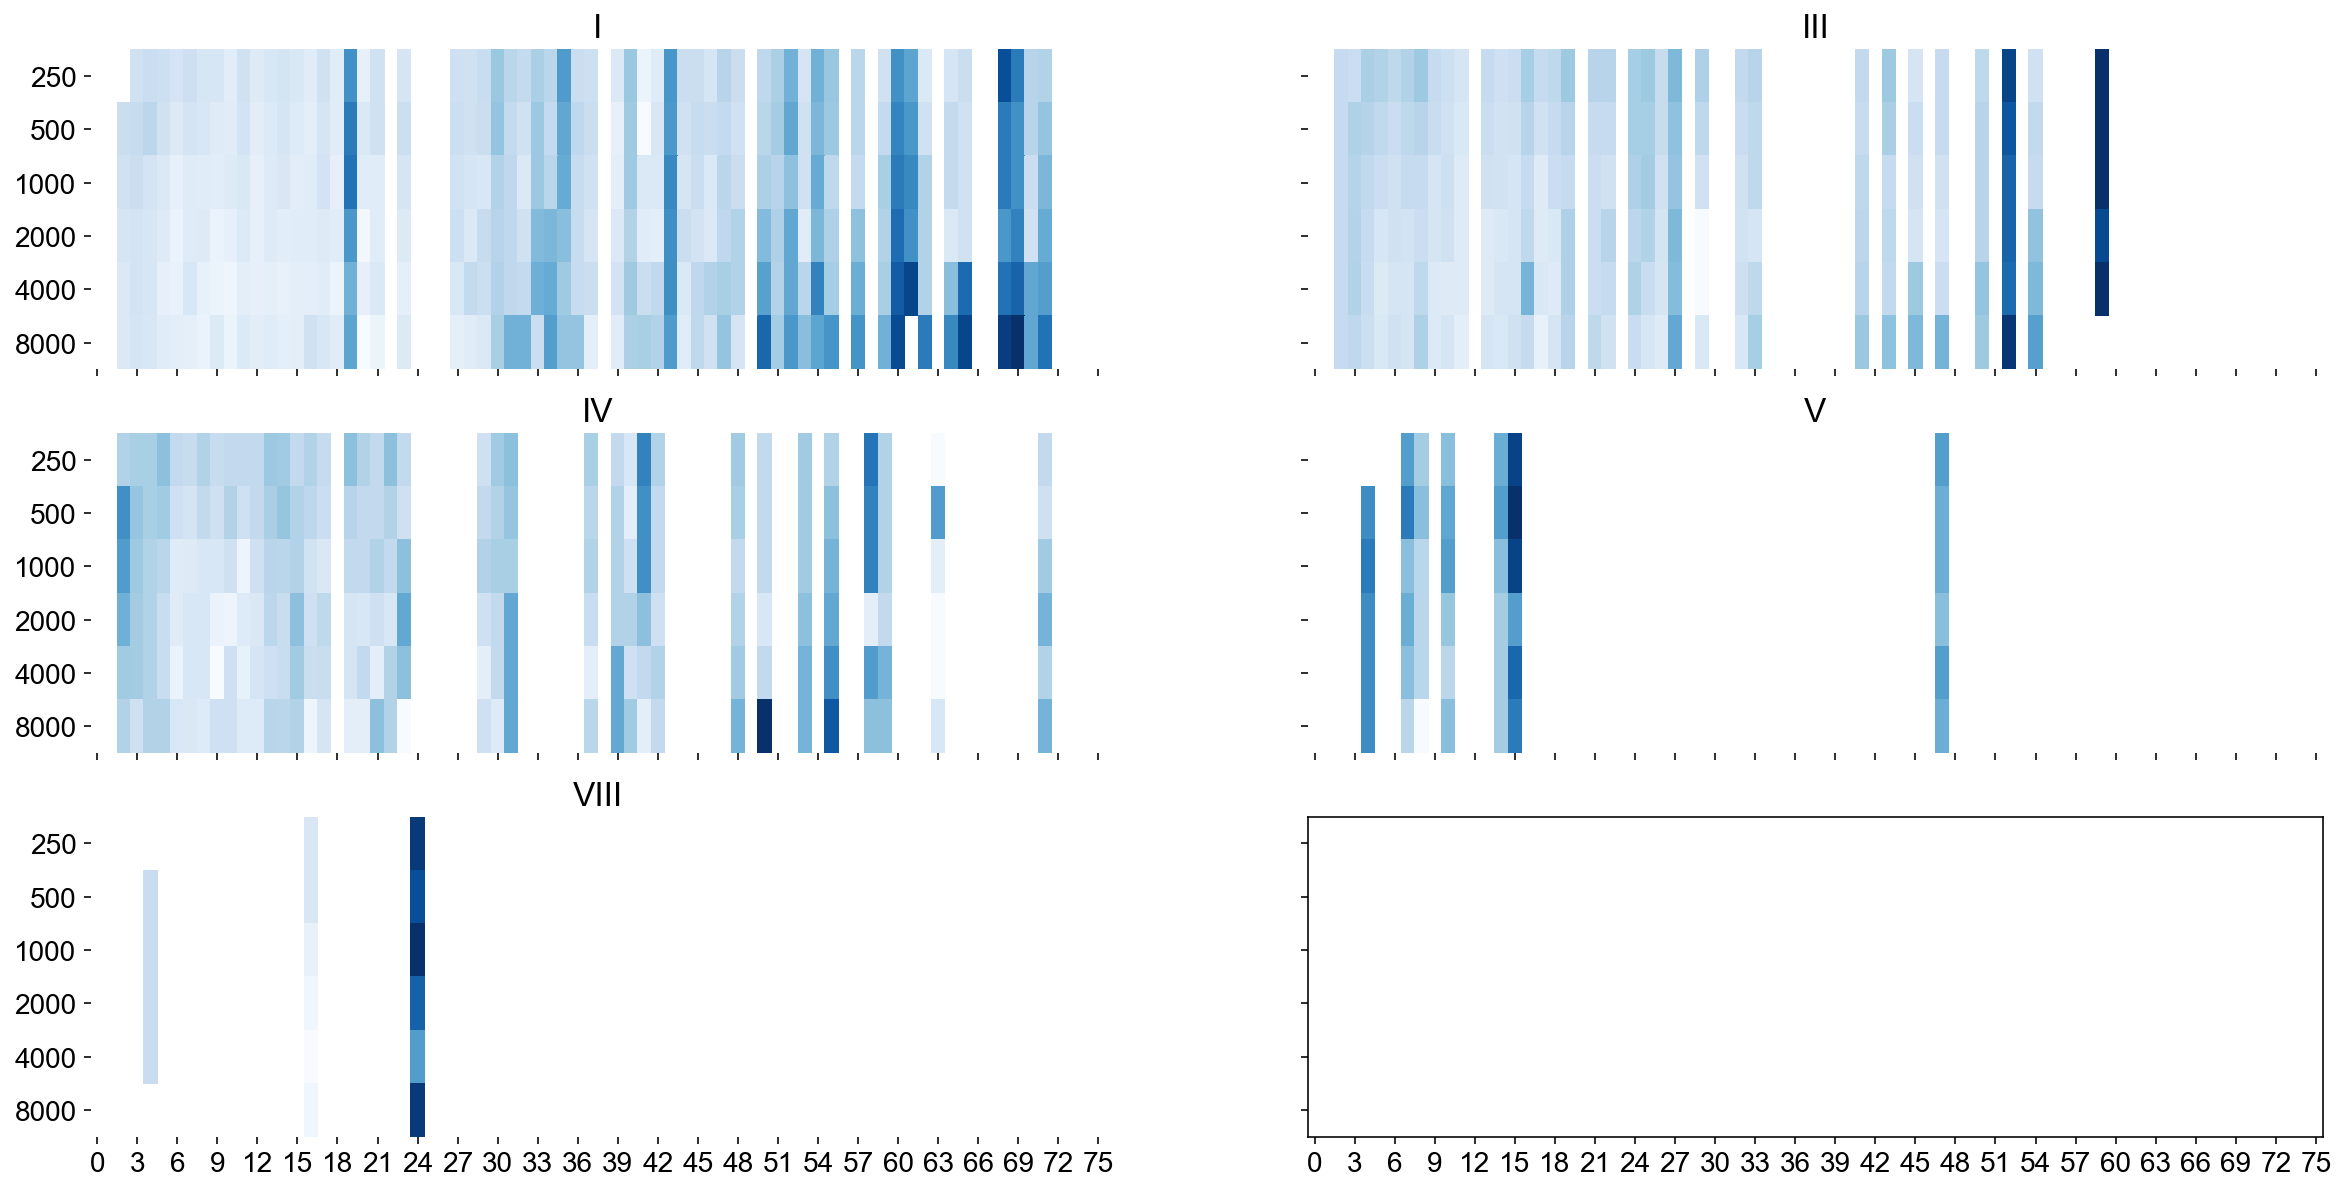

In [11]:
import seaborn as sns
for (oi, x), ax in zip(ears[ears['type']=='air'].groupby('Subtype of OI'), [i for j in plt.subplots(3,2,figsize=(20,10),sharex=True,sharey=True)[1] for i in j]):
  sns.heatmap(
    pd.crosstab(round(x['Age']),x['freq'],x['dB_loss'],aggfunc='mean').reindex(range(0,int(ears['Age'].max()))).T,
    cmap='Blues',ax=ax,cbar=False)
  ax.set_title(oi)
  ax.set_xlabel(None)
  ax.set_ylabel(None)

In [170]:
agg = ears[ears['freq'].isin([500,1000,2000])].groupby(['UID','Subtype of OI','Gender','Age','side','type'])['dB_loss'].agg(['mean','std']).reset_index()